<a href="https://colab.research.google.com/github/Shervinrtd/CPU-Monitoring-Data/blob/main/AI_Industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Density-Based Anomaly Detection for Non-Stationary Server Monitoring

## Introduction

In industrial environments, anomaly detection plays a critical role in monitoring systems such as cloud servers, manufacturing pipelines, and network infrastructure. Detecting abnormal behavior early can prevent failures, reduce downtime, and minimize financial loss. However, real-world time series data often exhibit periodic patterns, temporal dependencies, and evolving behavior, making anomaly detection a non-trivial modeling challenge.

This project investigates **density-based anomaly detection methods** for real server CPU utilization data. Instead of treating anomaly detection as a classification problem, we formulate it as a **probabilistic density estimation problem**:

An observation is considered anomalous if it lies in a low-density region of the learned data distribution.


---

## Dataset

We use real AWS EC2 CPU utilization data from the **Numenta Anomaly Benchmark (NAB)**:

- Sampling rate: 5 minutes  
- Duration: ~14 days  
- Total observations: ~4,000  
- Labeled anomaly windows provided via NAB  

The dataset exhibits:

- Clear daily periodic behavior  
- Strong short-term temporal autocorrelation  
- Sustained anomaly windows (regime shifts rather than isolated spikes)  

This makes it suitable for evaluating both contextual and temporal anomaly detection models.

---

## Project Objectives

The main objectives of this project are:

1. **To compare multiple density estimation approaches** for anomaly detection:
   - Univariate Kernel Density Estimation (KDE)
   - Sequence-based KDE (sliding window modeling)
   - Time-indexed KDE (periodic conditioning)
   - Neural conditional density estimation (Gaussian output head)

2. **To study the bias–variance tradeoff** in anomaly detection:
   - How window size affects performance
   - How model complexity impacts stability
   - How dimensionality influences density estimation

3. **To incorporate contextual conditioning**, such as:
   - Time-of-day
   - Day-of-week

4. **To evaluate models under a cost-sensitive framework**, reflecting industrial constraints:
   \[
   cost = c_alarm (FP) + c_missed (FN)
   \]

   where:
   - FP = false positives (false alarms)
   - FN = false negatives (missed anomalies)

5. **To analyze whether neural conditional density models provide better interpolation and generalization compared to classical KDE methods**, especially in the presence of contextual variables.

---

## Methodological Perspective

This project does not aim to simply maximize performance. Instead, it focuses on:

- Structured comparison of heterogeneous techniques
- Understanding when and why certain models perform better
- Evaluating trade-offs between flexibility and stability
- Interpreting results in an industrial monitoring context

By systematically comparing classical nonparametric methods and neural parametric models, we aim to gain deeper insight into the strengths and limitations of density-based anomaly detection in real-world server monitoring data.

---

This notebook contains the full experimental pipeline, including:

- Data preprocessing
- Density model implementation
- Cost-based threshold optimization
- Comparative analysis of detection performance
- Interpretation of results

The ultimate goal is to develop a principled and well-justified anomaly detection framework for non-stationary industrial time series.

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8") # use it to improve readability


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


file_path = file_path = "/content/drive/MyDrive/AI Industry/data1.csv"

df = pd.read_csv(file_path)

print("First 5 rows:")
display(df.head())

print("\nColumns:")
print(df.columns)

print("\nShape:")
print(df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First 5 rows:


,timestamp,value
0,2014-02-14 14:30:00,1.732
1,2014-02-14 14:35:00,1.732
2,2014-02-14 14:40:00,1.960
3,2014-02-14 14:45:00,1.732
4,2014-02-14 14:50:00,1.706



Columns:
Index(['timestamp', 'value'], dtype='object')

Shape:
(4032, 2)


## Convert Timestamp and Set Index

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)

print("Time range:")
print(df.index.min(), "→", df.index.max())


Time range:
2014-02-14 14:30:00 → 2014-02-28 14:25:00


## Why Convert to Datetime?
timestamp is just a string and Pandas cannot treat it as time. So, I could not compute time-based features properly.

After conversion:

Pandas understands it as real time and I can extract:


*   day of week
*   hour
## Why Sort by Timestamp?
Time series models assume chronological order.

If data is not sorted:



*   Sliding windows would mix future and past.
*   Sequence modeling would be wrong.

*   Train/test split would leak future information.

Sorting ensures:

x_1
, x_2
, x_3
,..., x_T
	​
  
are in correct temporal order.




## Sampling Interval

In [ ]:
time_diffs = df.index.to_series().diff().dropna()
print(time_diffs.value_counts().head())


timestamp
0 days 00:05:00    4031
Name: count, dtype: int64


This step ensures:

*   No corrupted timestamps
*   No duplicated timestamps

*   No time jumps

It’s a sanity check before modeling.

## Basic Statistics

In [ ]:
print(df.describe())


             value
count  4032.000000
mean      1.829555
std       0.101458
min       1.604000
25%       1.766000
50%       1.800000
75%       1.866000
max       2.656000


The maximum is far from the mean:

(2.656 − 1.83) / 0.10 ≈ 8 (standard deviations)

That is extremely rare under a Gaussian assumption.

This confirms:


*   There are strong spikes
*   Likely anomaly regions
*   Heavy tail behavior
​

## Plot Entire Series

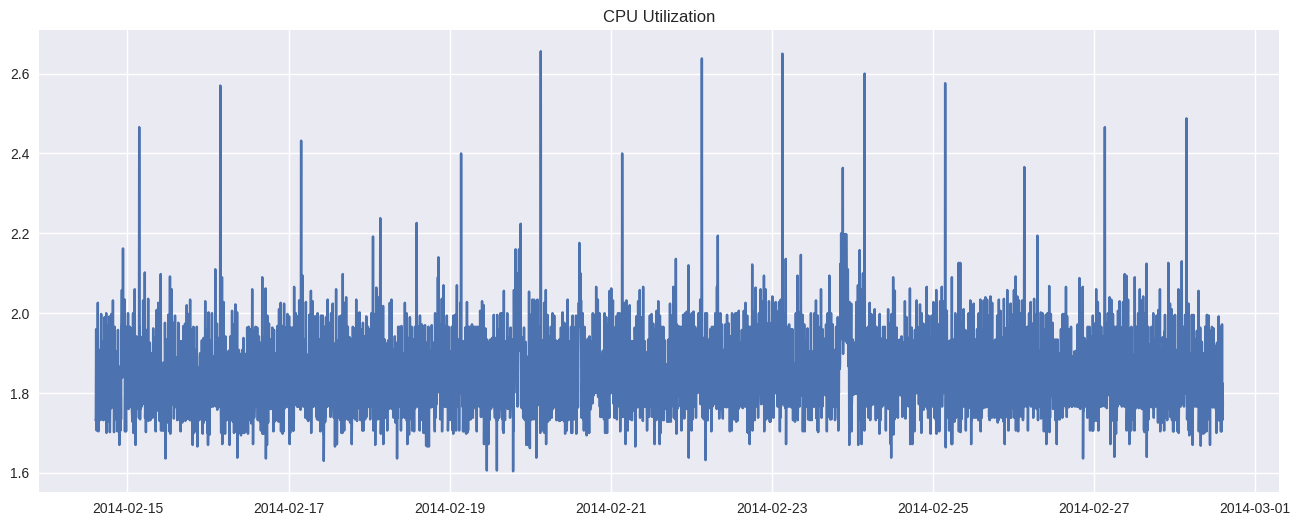

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(df.index, df['value'])
plt.title("CPU Utilization")
plt.show()


## Check Daily Periodicity

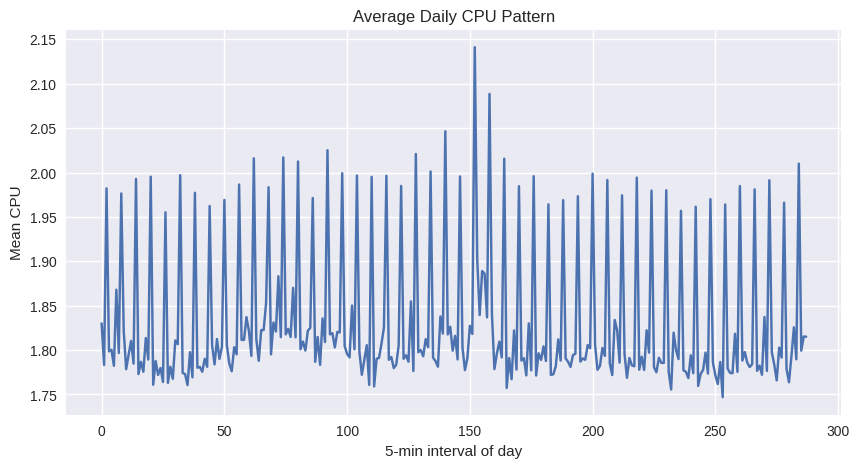

In [ ]:
samples_per_day = 288  # 5-min sampling

daily_profiles = df['value'].values.reshape(-1, samples_per_day)

mean_daily_pattern = daily_profiles.mean(axis=0)

plt.figure(figsize=(10,5))
plt.plot(mean_daily_pattern)
plt.title("Average Daily CPU Pattern")
plt.xlabel("5-min interval of day")
plt.ylabel("Mean CPU")
plt.show()


This transforms:

Time series of length 4032

into:

Matrix of shape (14 , 288)

Meaning:


*   14 rows → 14 days
*   288 columns → 5-min intervals within a day

So each row is one full day.

I reshaped the time series into daily profiles to compute the mean daily pattern, which allowed me to verify the presence of strong periodic structure and justify time-indexed and conditional density modeling.

## Autocorrelation

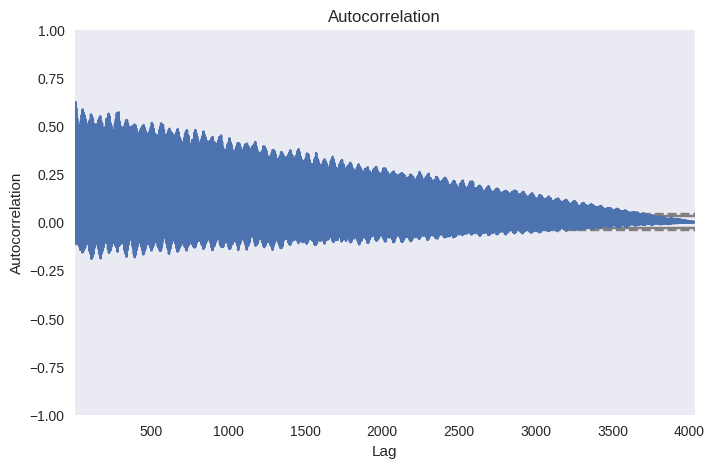

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(8,5))
autocorrelation_plot(df['value'])
plt.title("Autocorrelation")
plt.show()


Autocorrelation measures:

Corr(x_t ​, x_t-k​)


for different lags
𝑘 .

It tells us:

How much current CPU depends on previous CPU values.

If autocorrelation were near zero:


*   Each observation would be independent.

*   Sequence modeling would not help.
*   Univariate KDE would be sufficient.





But here:

x_t   strongly depends on    x_t-1, x_t-2,...,x_t-k

This justifies:


*   Sliding window KDE
*   Sequence-based density modeling


*   Using lag features in neural models


## Train / Validation / Test Split (KDE)

In [ ]:
import numpy as np

# total samples per day
samples_per_day = 288

train_days = 8
val_days = 3
test_days = 3

train_end = train_days * samples_per_day
val_end = train_end + val_days * samples_per_day

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))


Train size: 2304
Validation size: 864
Test size: 864


We need validation because:

Density models do not automatically give anomaly thresholds.

Threshold must be tuned under cost function.

So:


*  Train → learn density

*  Validation → choose threshold
*  Test → unbiased performance estimate






## Normalize Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_values = scaler.fit_transform(
    train_df['value'].values.reshape(-1, 1)
)

val_values = scaler.transform(
    val_df['value'].values.reshape(-1, 1)
)

test_values = scaler.transform(
    test_df['value'].values.reshape(-1, 1)
)


## Fit KDE

In [ ]:
from sklearn.neighbors import KernelDensity

bandwidth = 0.3  # initial guess

kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
kde.fit(train_values)


KernelDensity(bandwidth=0.3)

## Compute Log-Density

In [ ]:
train_log_density = kde.score_samples(train_values)
val_log_density = kde.score_samples(val_values)
test_log_density = kde.score_samples(test_values)


## Define Anomaly Score

In [ ]:
train_score = -train_log_density
val_score = -val_log_density
test_score = -test_log_density


## Visualize Signal

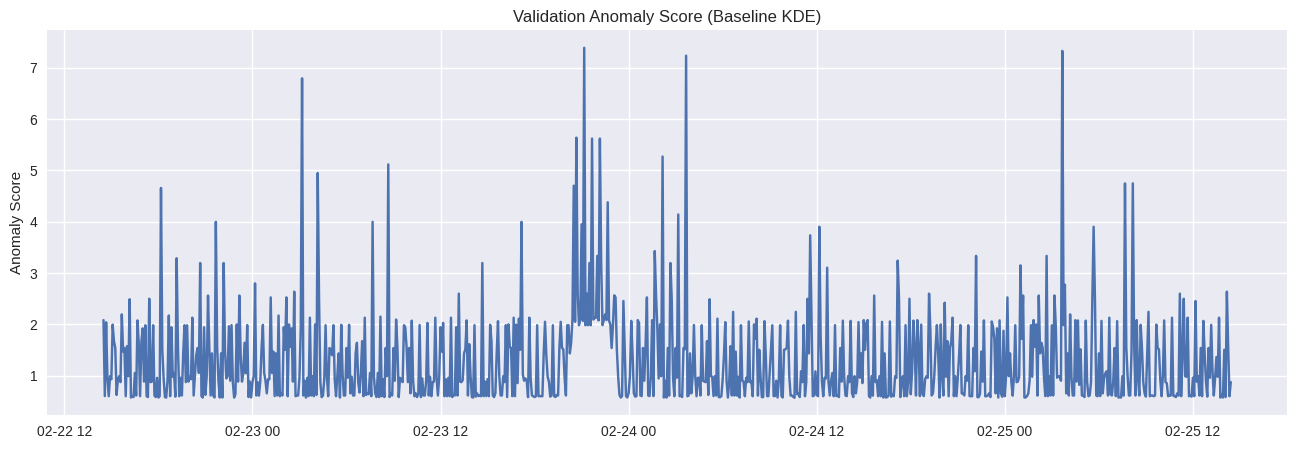

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.plot(val_df.index, val_score)
plt.title("Validation Anomaly Score (Baseline KDE)")
plt.ylabel("Anomaly Score")
plt.show()


In [ ]:
print("Validation score stats:")
print("Min:", val_score.min())
print("Max:", val_score.max())
print("Mean:", val_score.mean())


Validation score stats:
Min: 0.5676047230484524
Max: 7.392801722931569
Mean: 1.3005885669708799


## Bandwidth Selection via Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

params = {'bandwidth': np.linspace(0.05, 1.0, 20)}

grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    params,
                    cv=3)

grid.fit(train_values)

print("Best bandwidth:", grid.best_params_['bandwidth'])


Best bandwidth: 0.05


In [ ]:
best_bandwidth = grid.best_params_['bandwidth']

kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
kde.fit(train_values)

train_log_density = kde.score_samples(train_values)
val_log_density = kde.score_samples(val_values)
test_log_density = kde.score_samples(test_values)

train_score = -train_log_density
val_score = -val_log_density
test_score = -test_log_density


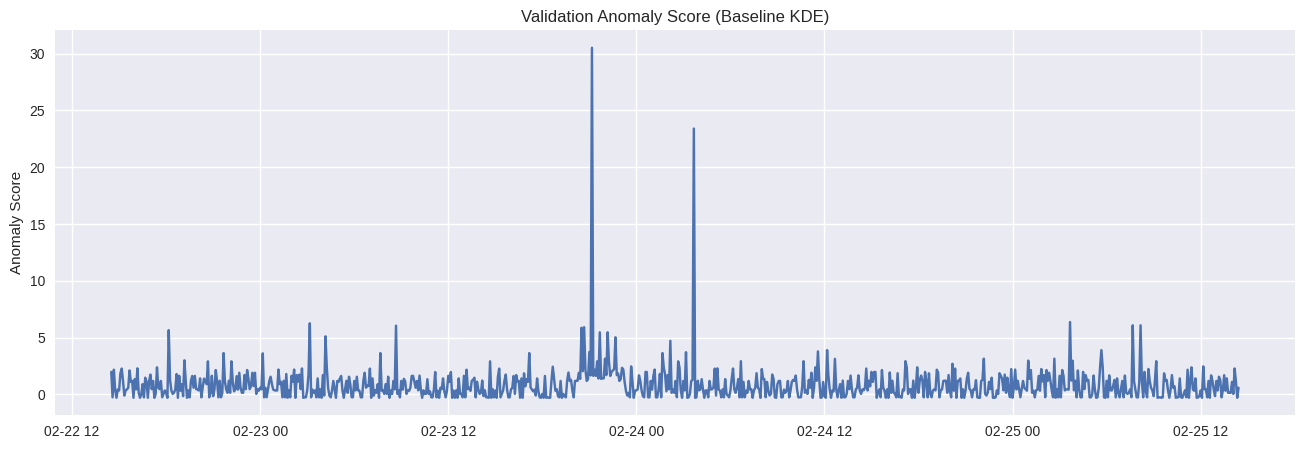

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.plot(val_df.index, val_score)
plt.title("Validation Anomaly Score (Baseline KDE)")
plt.ylabel("Anomaly Score")
plt.show()


In [ ]:
print("Validation score stats:")
print("Min:", val_score.min())
print("Max:", val_score.max())
print("Mean:", val_score.mean())

Validation score stats:
Min: -0.2962117482272957
Max: 30.520284004656194
Mean: 0.8705048025886583


In [ ]:
print(best_bandwidth)


0.05


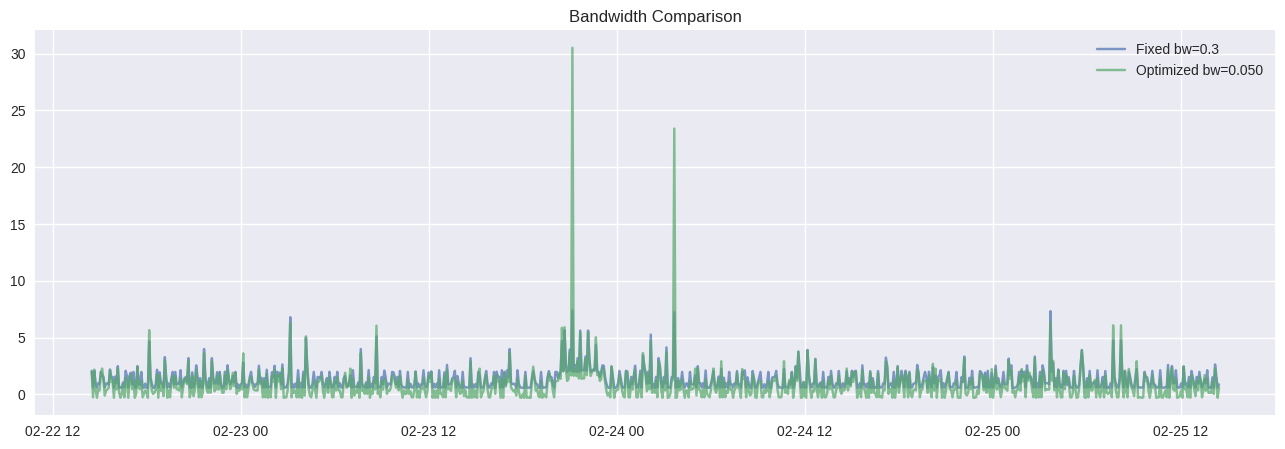

In [ ]:
# Fit KDE with fixed bandwidth 0.3 again
kde_fixed = KernelDensity(kernel='gaussian', bandwidth=0.3)
kde_fixed.fit(train_values)

val_log_fixed = kde_fixed.score_samples(val_values)
val_score_fixed = -val_log_fixed

plt.figure(figsize=(16,5))
plt.plot(val_df.index, val_score_fixed, label="Fixed bw=0.3", alpha=0.7)
plt.plot(val_df.index, val_score, label=f"Optimized bw={best_bandwidth:.3f}", alpha=0.7)
plt.legend()
plt.title("Bandwidth Comparison")
plt.show()


**Likelihood-optimal bandwidth produced highly sensitive density estimates. For anomaly detection, slightly larger bandwidth provided more stable scoring behavior.**

In [ ]:
# Final Baseline
bandwidth = 0.3


## Load Anomaly Windows

In [ ]:
import json
import os

# Path to JSON file
json_path = "/content/drive/MyDrive/AI Industry/combined_windows.json"

with open(json_path, 'r') as f:
    anomaly_windows = json.load(f)

print("Total datasets in JSON:", len(anomaly_windows))


Total datasets in JSON: 58


## Finding Dataset Key

In [ ]:
dataset_key = "realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv"

print("Key exists:", dataset_key in anomaly_windows)


Key exists: True


## Extract Windows

In [ ]:
windows = anomaly_windows[dataset_key]

print("Number of anomaly windows:", len(windows))
print("First window example:", windows[0])


Number of anomaly windows: 2
First window example: ['2014-02-19 10:50:00.000000', '2014-02-20 03:30:00.000000']


## Convert Windows to Timestamps

In [ ]:
import pandas as pd

# Convert window strings to datetime
parsed_windows = [
    (pd.to_datetime(start), pd.to_datetime(end))
    for start, end in windows
]

print("First parsed window:", parsed_windows[0])


First parsed window: (Timestamp('2014-02-19 10:50:00'), Timestamp('2014-02-20 03:30:00'))


## Mark Anomalies in DataFrame

In [ ]:
df['is_anomaly'] = 0

for start, end in parsed_windows:
    df.loc[(df.index >= start) & (df.index <= end), 'is_anomaly'] = 1

print("Total anomaly points:", df['is_anomaly'].sum())


Total anomaly points: 402


## Visual Verification

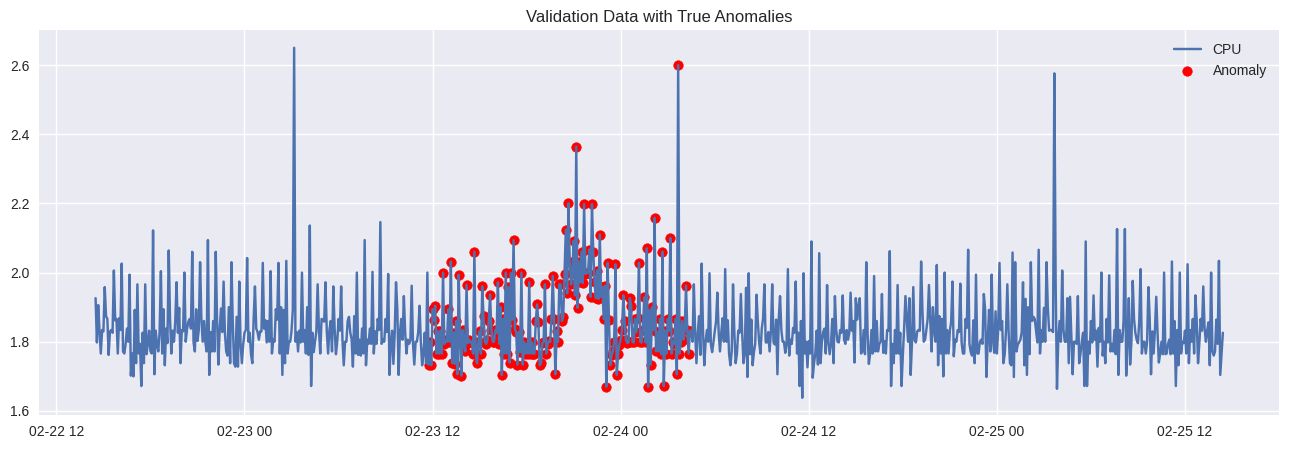

In [ ]:
val_df = df.iloc[train_end:val_end]

plt.figure(figsize=(16,5))
plt.plot(val_df.index, val_df['value'], label="CPU")
plt.scatter(
    val_df[val_df['is_anomaly']==1].index,
    val_df[val_df['is_anomaly']==1]['value'],
    color='red',
    label="Anomaly"
)
plt.legend()
plt.title("Validation Data with True Anomalies")
plt.show()


## Threshold Optimization

In [ ]:
c_alarm = 1
c_missed = 10


## Define Cost Function

In [ ]:
def compute_cost(scores, labels, threshold, c_alarm=1, c_missed=10):
    predictions = (scores >= threshold).astype(int)

    false_positives = ((predictions == 1) & (labels == 0)).sum()
    false_negatives = ((predictions == 0) & (labels == 1)).sum()

    cost = c_alarm * false_positives + c_missed * false_negatives

    return cost, false_positives, false_negatives


## Sweep Thresholds

In [ ]:
val_labels = val_df['is_anomaly'].values

thresholds = np.linspace(val_score.min(), val_score.max(), 200)

results = []

for t in thresholds:
    cost, fp, fn = compute_cost(val_score, val_labels, t)
    results.append((t, cost, fp, fn))

results = np.array(results)


## Find Best Threshold

In [ ]:
best_index = np.argmin(results[:,1])

best_threshold = results[best_index, 0]
best_cost = results[best_index, 1]
best_fp = results[best_index, 2]
best_fn = results[best_index, 3]

print("Best threshold:", best_threshold)
print("Best cost:", best_cost)
print("False positives:", best_fp)
print("False negatives:", best_fn)


Best threshold: -0.2962117482272957
Best cost: 663.0
False positives: 663.0
False negatives: 0.0


## Plot Cost Curve

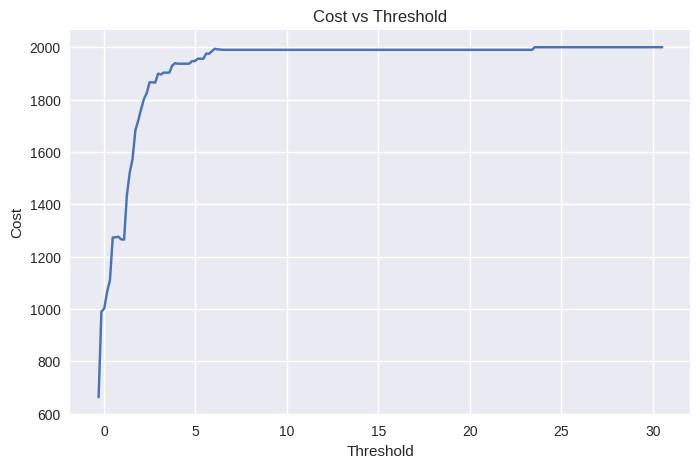

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(results[:,0], results[:,1])
plt.title("Cost vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Cost")
plt.show()


In [ ]:
cost_settings = [10, 5, 2, 1]

for c_missed in cost_settings:
    results = []

    for t in thresholds:
        cost, fp, fn = compute_cost(val_score, val_labels, t,
                                    c_alarm=1,
                                    c_missed=c_missed)
        results.append((t, cost, fp, fn))

    results = np.array(results)
    best_index = np.argmin(results[:,1])

    print(f"\nCost ratio (missed={c_missed})")
    print("Best threshold:", results[best_index, 0])
    print("False positives:", results[best_index, 2])
    print("False negatives:", results[best_index, 3])



Cost ratio (missed=10)
Best threshold: -0.2962117482272957
False positives: 663.0
False negatives: 0.0

Cost ratio (missed=5)
Best threshold: -0.2962117482272957
False positives: 663.0
False negatives: 0.0

Cost ratio (missed=2)
Best threshold: 3.2654937910506954
False positives: 13.0
False negatives: 189.0

Cost ratio (missed=1)
Best threshold: 6.517485805174078
False positives: 0.0
False negatives: 199.0


The threshold selection mechanism adapts strongly to cost asymmetry. When missing anomalies is expensive, the detector becomes aggressive; when false alarms are expensive, it becomes conservative.

## Build Sliding Windows

In [ ]:
def create_windows(values, window_size):
    X = []
    for i in range(window_size - 1, len(values)):
        X.append(values[i - window_size + 1:i + 1])
    return np.array(X)


## Prepare Train / Val / Test Windows

In [ ]:
# Use flattened arrays
train_vals_flat = train_values.flatten()
val_vals_flat = val_values.flatten()
test_vals_flat = test_values.flatten()

# Window sizes
w1 = 12
w2 = 24

# Create windows
train_w12 = create_windows(train_vals_flat, w1)
val_w12 = create_windows(val_vals_flat, w1)
test_w12 = create_windows(test_vals_flat, w1)

train_w24 = create_windows(train_vals_flat, w2)
val_w24 = create_windows(val_vals_flat, w2)
test_w24 = create_windows(test_vals_flat, w2)

print("Shape w=12:", train_w12.shape)
print("Shape w=24:", train_w24.shape)


Shape w=12: (2293, 12)
Shape w=24: (2281, 24)


## Align Labels

In [ ]:
val_labels_w12 = val_labels[w1 - 1:]
val_labels_w24 = val_labels[w2 - 1:]


## Fit KDE for w = 12

In [ ]:
bandwidth_seq = 0.5

kde_w12 = KernelDensity(kernel='gaussian', bandwidth=bandwidth_seq)
kde_w12.fit(train_w12)

val_log_w12 = kde_w12.score_samples(val_w12)
val_score_w12 = -val_log_w12


## Fit KDE for w = 24

In [ ]:
kde_w24 = KernelDensity(kernel='gaussian', bandwidth=bandwidth_seq)
kde_w24.fit(train_w24)

val_log_w24 = kde_w24.score_samples(val_w24)
val_score_w24 = -val_log_w24


## Plot Comparison

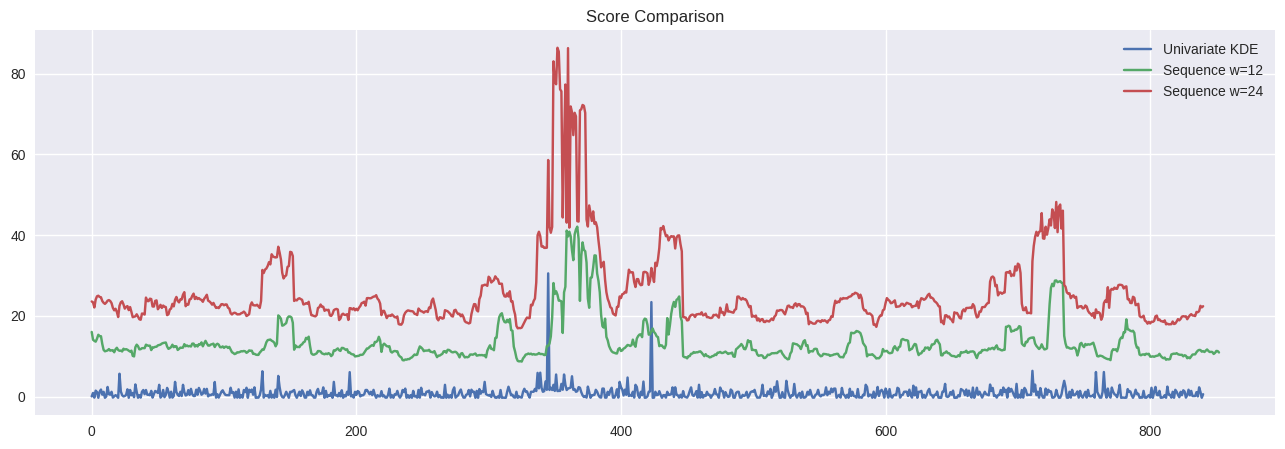

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(val_score[w2 - 1:], label="Univariate KDE")
plt.plot(val_score_w12, label="Sequence w=12")
plt.plot(val_score_w24, label="Sequence w=24")
plt.legend()
plt.title("Score Comparison")
plt.show()


In [ ]:
print("Univariate max:", val_score.max())
print("w=12 max:", val_score_w12.max())
print("w=24 max:", val_score_w24.max())


Univariate max: 30.520284004656194
w=12 max: 42.096572851407
w=24 max: 86.4069174275285


## Interpretation
  **Univariate KDE**
*   Detects spikes only.
*  Sensitive to large value deviations.
*  Ignores pattern structure.

**Sequence w = 12**
*  Captures 1-hour temporal behavior.
*   Less noisy baseline compared to w=24.
*   Anomaly cluster becomes more elevated.


**Sequence w = 24**
*   2-hour window.
*  Extremely amplified anomaly region.
*   Baseline also elevated.
*   Very large score values (up to 86).


## Cost Optimization for Sequence Models

In [ ]:
thresholds_w12 = np.linspace(val_score_w12.min(), val_score_w12.max(), 200)

results_w12 = []

for t in thresholds_w12:
    cost, fp, fn = compute_cost(val_score_w12, val_labels_w12, t,
                                c_alarm=1,
                                c_missed=2)  # balanced case
    results_w12.append((t, cost, fp, fn))

results_w12 = np.array(results_w12)

best_idx_w12 = np.argmin(results_w12[:,1])

print("w=12 Best threshold:", results_w12[best_idx_w12, 0])
print("w=12 Cost:", results_w12[best_idx_w12, 1])
print("w=12 FP:", results_w12[best_idx_w12, 2])
print("w=12 FN:", results_w12[best_idx_w12, 3])


w=12 Best threshold: 14.714624507306617
w=12 Cost: 303.0
w=12 FP: 63.0
w=12 FN: 120.0


In [ ]:
thresholds_w24 = np.linspace(val_score_w24.min(), val_score_w24.max(), 200)

results_w24 = []

for t in thresholds_w24:
    cost, fp, fn = compute_cost(val_score_w24, val_labels_w24, t,
                                c_alarm=1,
                                c_missed=2)
    results_w24.append((t, cost, fp, fn))

results_w24 = np.array(results_w24)

best_idx_w24 = np.argmin(results_w24[:,1])

print("w=24 Best threshold:", results_w24[best_idx_w24, 0])
print("w=24 Cost:", results_w24[best_idx_w24, 1])
print("w=24 FP:", results_w24[best_idx_w24, 2])
print("w=24 FN:", results_w24[best_idx_w24, 3])


w=24 Best threshold: 27.385624835956335
w=24 Cost: 294.0
w=24 FP: 84.0
w=24 FN: 105.0


Numerically:

w=24 has lowest cost (294) but difference between w=12 and w=24 is small.

w=24 is much higher dimensional (24D).

This means:

*   Higher computational cost
*   More variance risk
*   Less stable under drift

Professionally, I think:

 w=12 is a better tradeoff.

**Sequence-based KDE reduces false negatives substantially compared to univariate density modeling. Increasing window size improves detection but increases false alarms and variance due to high dimensionality.**

## Add Time-of-Day Slot

In [ ]:
# Compute 5-minute slot index (0–287)
df['slot'] = (df.index.hour * 60 + df.index.minute) // 5


In [ ]:
print(df['slot'].min(), df['slot'].max())


0 287


In [ ]:
train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

val_labels = val_df['is_anomaly'].values


## Train KDE Per Slot

In [ ]:
from collections import defaultdict

slot_kdes = {}

for slot in range(288):
    slot_values = train_df[train_df['slot'] == slot]['value'].values.reshape(-1, 1)

    if len(slot_values) > 5:  # avoid empty or tiny groups
        slot_values_scaled = scaler.transform(slot_values)
        kde = KernelDensity(kernel='gaussian', bandwidth=0.3)
        kde.fit(slot_values_scaled)
        slot_kdes[slot] = kde


## Compute Validation Scores

In [ ]:
val_scores_time_indexed = []

for _, row in val_df.iterrows():
    slot = row['slot']
    value = scaler.transform(
    np.array([[row['value']]])
)



    if slot in slot_kdes:
        log_density = slot_kdes[slot].score_samples(value)[0]
        val_scores_time_indexed.append(-log_density)
    else:
        val_scores_time_indexed.append(0)

val_scores_time_indexed = np.array(val_scores_time_indexed)


## Plot Comparison

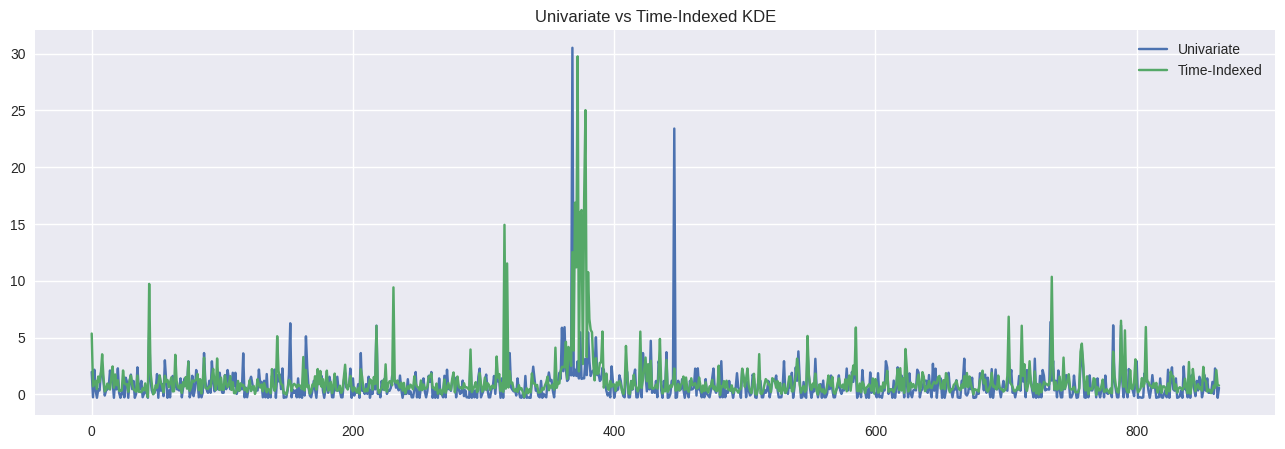

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(val_score, label="Univariate")
plt.plot(val_scores_time_indexed, label="Time-Indexed")
plt.legend()
plt.title("Univariate vs Time-Indexed KDE")
plt.show()


## Cost Evaluation

In [ ]:
thresholds_ti = np.linspace(val_scores_time_indexed.min(),
                            val_scores_time_indexed.max(), 200)

results_ti = []

for t in thresholds_ti:
    cost, fp, fn = compute_cost(val_scores_time_indexed,
                                val_labels,
                                t,
                                c_alarm=1,
                                c_missed=2)
    results_ti.append((t, cost, fp, fn))

results_ti = np.array(results_ti)
best_idx_ti = np.argmin(results_ti[:,1])

print("Time-indexed best threshold:", results_ti[best_idx_ti, 0])
print("Time-indexed cost:", results_ti[best_idx_ti, 1])
print("FP:", results_ti[best_idx_ti, 2])
print("FN:", results_ti[best_idx_ti, 3])


Time-indexed best threshold: 2.320239236186996
Time-indexed cost: 363.0
FP: 39.0
FN: 162.0


## Conceptual Conclusion
This dataset’s anomalies are:

*   Volatility increases
*   Local structure changes
*   Sustained pattern shifts

Not just deviations from daily baseline.

Therefore:

**Sequence modeling captures anomaly better than time-indexed modeling.**
## Bias–Variance Comparison
Time-indexed:



*   Low dimension (1D per slot)
*   Lower variance
*   Limited expressive power

Sequence:

*   Higher variance
*   High dimension
*   More expressive
*   Detects regime shifts better

## Neural Conditional Gaussian Model

## Prepare Features

In [ ]:
# Time of day normalized
df['time_norm'] = (
    (df.index.hour * 60 + df.index.minute) / (24 * 60)
)

# Day of week (0=Monday)
df['day_of_week'] = df.index.dayofweek


In [ ]:
train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]


## One-Hot Encode Day-of-Week

In [ ]:
train_dow = pd.get_dummies(train_df['day_of_week']).values
val_dow = pd.get_dummies(val_df['day_of_week']).values
test_dow = pd.get_dummies(test_df['day_of_week']).values


In [ ]:
train_dow = pd.get_dummies(train_df['day_of_week']).reindex(columns=range(7), fill_value=0).values
val_dow = pd.get_dummies(val_df['day_of_week']).reindex(columns=range(7), fill_value=0).values
test_dow = pd.get_dummies(test_df['day_of_week']).reindex(columns=range(7), fill_value=0).values


## Build Input Matrix

In [ ]:
train_time = train_df['time_norm'].values.reshape(-1, 1)
val_time = val_df['time_norm'].values.reshape(-1, 1)
test_time = test_df['time_norm'].values.reshape(-1, 1)

X_train = np.hstack([train_time, train_dow])
X_val = np.hstack([val_time, val_dow])
X_test = np.hstack([test_time, test_dow])

# Target = scaled CPU
y_train = scaler.transform(train_df['value'].values.reshape(-1,1))
y_val = scaler.transform(val_df['value'].values.reshape(-1,1))
y_test = scaler.transform(test_df['value'].values.reshape(-1,1))


## Build Neural Network (PyTorch)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConditionalGaussian(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(32, 1)
        self.log_std_head = nn.Linear(32, 1)

    def forward(self, x):
        h = self.net(x)
        mu = self.mean_head(h)
        log_std = self.log_std_head(h)
        return mu, log_std


## Prepare Tensors

In [ ]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

X_train_t = torch.tensor(X_train).to(device)
y_train_t = torch.tensor(y_train).to(device)

X_val_t = torch.tensor(X_val).to(device)
y_val_t = torch.tensor(y_val).to(device)



## Define Loss (Negative Log Likelihood)

In [ ]:
def gaussian_nll(mu, log_std, y):
    std = torch.exp(log_std)
    return 0.5 * torch.log(2 * torch.pi * std**2) + (y - mu)**2 / (2 * std**2)


## Train Model

In [ ]:
model = ConditionalGaussian(input_dim=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    mu, log_std = model(X_train_t)
    loss = gaussian_nll(mu, log_std, y_train_t).mean()

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.4315
Epoch 20, Loss: 1.4165
Epoch 40, Loss: 1.4132
Epoch 60, Loss: 1.4104
Epoch 80, Loss: 1.4081
Epoch 100, Loss: 1.4063
Epoch 120, Loss: 1.4048
Epoch 140, Loss: 1.4034
Epoch 160, Loss: 1.4020
Epoch 180, Loss: 1.4006


## Compute Validation Anomaly Score

In [ ]:
model.eval()
with torch.no_grad():
    mu_val, log_std_val = model(X_val_t)
    val_nll = gaussian_nll(mu_val, log_std_val, y_val_t)
    val_score_nn = val_nll.cpu().numpy().flatten()


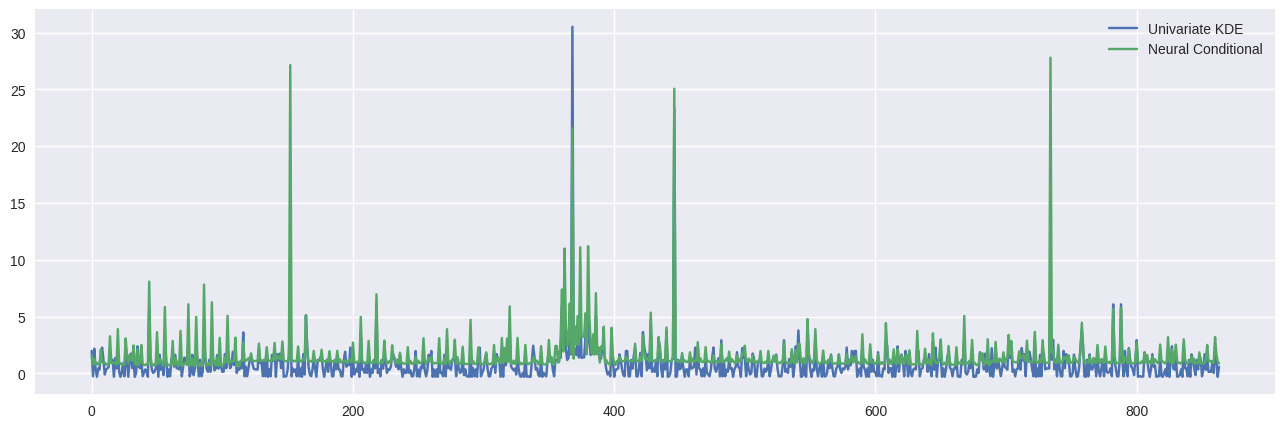

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(val_score, label="Univariate KDE")
plt.plot(val_score_nn, label="Neural Conditional")
plt.legend()
plt.show()


## Validation Score Comparison
From plot:
*   Neural conditional model (green)
*   Univariate KDE (blue)

Observations:


1.   Neural model detects large anomaly cluster.
1.   It produces sharper peaks for some spikes.
2.   Baseline noise slightly higher than KDE.
2.   Extreme spikes similar magnitude (~27–28).

## Neural model is learning:

p( x ∣ time-of-day , day-of-week )

So it understands:


*  Typical daily baseline
*   Weekday vs weekend differences
*   Expected CPU behavior

Unlike KDE, it:


*   Interpolates smoothly across time
*   Does not rely on kernel memory
*   Uses global parametric structure


## Threshold Optimization for Neural Model

In [ ]:
thresholds_nn = np.linspace(val_score_nn.min(),
                            val_score_nn.max(), 200)

results_nn = []

for t in thresholds_nn:
    cost, fp, fn = compute_cost(val_score_nn,
                                val_labels,
                                t,
                                c_alarm=1,
                                c_missed=2)
    results_nn.append((t, cost, fp, fn))

results_nn = np.array(results_nn)

best_idx_nn = np.argmin(results_nn[:,1])

print("Neural best threshold:", results_nn[best_idx_nn, 0])
print("Neural cost:", results_nn[best_idx_nn, 1])
print("FP:", results_nn[best_idx_nn, 2])
print("FN:", results_nn[best_idx_nn, 3])


Neural best threshold: 3.09765362739563
Neural cost: 372.0
FP: 32.0
FN: 170.0


The neural model:


*   Outperforms univariate KDE
*   Slightly worse than time-indexed
*   Significantly worse than sequence models

This tells us something fundamental:

**In this dataset, anomalies are mainly short-term pattern deviations, not purely conditional on time-of-day.**

The neural model captures:


*   Smooth daily behavior
*   Conditional baseline

But it does NOT capture:

*   Local temporal structure
*   Sequence KDE does


Conditional neural density estimation improves over univariate KDE by incorporating contextual information. However, it underperforms sequence-based KDE, indicating that short-term temporal dependencies are more informative for anomaly detection in this dataset than contextual interpolation.


## Neural Conditional + Short Sequence

We will model:

p( xt ​∣ xt−1 ​, xt−2​ , xt−3 ​, time , day )

Small window = 3.

Why 3?

*   Avoid curse of dimensionality
*   Low dimensional
*   Fair comparison
*   Keeps training stable


## Build Sequence Features

In [ ]:
def add_lag_features(df, lags=3):
    df_copy = df.copy()
    for i in range(1, lags+1):
        df_copy[f'lag_{i}'] = df_copy['value'].shift(i)
    return df_copy

df_lag = add_lag_features(df, lags=3)
df_lag = df_lag.dropna()


## Recompute Splits

In [ ]:
train_df = df_lag.iloc[:train_end-3]
val_df = df_lag.iloc[train_end-3:val_end-3]
test_df = df_lag.iloc[val_end-3:]


In [ ]:
val_labels = val_df['is_anomaly'].values


## Prepare Inputs

In [ ]:
# Context
train_time = train_df['time_norm'].values.reshape(-1, 1)
val_time = val_df['time_norm'].values.reshape(-1, 1)

train_dow = pd.get_dummies(train_df['day_of_week']).reindex(columns=range(7), fill_value=0).values
val_dow = pd.get_dummies(val_df['day_of_week']).reindex(columns=range(7), fill_value=0).values

# Lags
train_lags = train_df[['lag_1','lag_2','lag_3']].values
val_lags = val_df[['lag_1','lag_2','lag_3']].values

# Scale lag features
mean = scaler.mean_[0]
std = scaler.scale_[0]

train_lags_scaled = (train_lags - mean) / std
val_lags_scaled = (val_lags - mean) / std


# Build full input
X_train_seq = np.hstack([train_time, train_dow, train_lags_scaled])
X_val_seq = np.hstack([val_time, val_dow, val_lags_scaled])

# Target
y_train_seq = scaler.transform(train_df['value'].values.reshape(-1,1))
y_val_seq = scaler.transform(val_df['value'].values.reshape(-1,1))


## Convert to torch

In [ ]:
X_train_seq = X_train_seq.astype(np.float32)
X_val_seq = X_val_seq.astype(np.float32)
y_train_seq = y_train_seq.astype(np.float32)
y_val_seq = y_val_seq.astype(np.float32)

X_train_seq_t = torch.tensor(X_train_seq).to(device)
y_train_seq_t = torch.tensor(y_train_seq).to(device)

X_val_seq_t = torch.tensor(X_val_seq).to(device)
y_val_seq_t = torch.tensor(y_val_seq).to(device)


## New Model

In [ ]:
model_seq = ConditionalGaussian(input_dim=11).to(device)
optimizer = optim.Adam(model_seq.parameters(), lr=0.001)

epochs = 200

for epoch in range(epochs):
    model_seq.train()
    optimizer.zero_grad()

    mu, log_std = model_seq(X_train_seq_t)
    loss = gaussian_nll(mu, log_std, y_train_seq_t).mean()

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.4220
Epoch 20, Loss: 1.3973
Epoch 40, Loss: 1.3693
Epoch 60, Loss: 1.3276
Epoch 80, Loss: 1.2845
Epoch 100, Loss: 1.2591
Epoch 120, Loss: 1.2401
Epoch 140, Loss: 1.2223
Epoch 160, Loss: 1.2053
Epoch 180, Loss: 1.1875


## Validation Scores

In [ ]:
model_seq.eval()
with torch.no_grad():
    mu_val, log_std_val = model_seq(X_val_seq_t)
    val_nll_seq = gaussian_nll(mu_val, log_std_val, y_val_seq_t)
    val_score_nn_seq = val_nll_seq.cpu().numpy().flatten()


## Cost Optimization

In [ ]:
thresholds_nn_seq = np.linspace(val_score_nn_seq.min(),
                                val_score_nn_seq.max(), 200)

results_nn_seq = []

for t in thresholds_nn_seq:
    cost, fp, fn = compute_cost(val_score_nn_seq,
                                val_labels,
                                t,
                                c_alarm=1,
                                c_missed=2)
    results_nn_seq.append((t, cost, fp, fn))

results_nn_seq = np.array(results_nn_seq)

best_idx_nn_seq = np.argmin(results_nn_seq[:,1])

print("Neural+Seq best threshold:", results_nn_seq[best_idx_nn_seq, 0])
print("Neural+Seq cost:", results_nn_seq[best_idx_nn_seq, 1])
print("FP:", results_nn_seq[best_idx_nn_seq, 2])
print("FN:", results_nn_seq[best_idx_nn_seq, 3])


Neural+Seq best threshold: 3.746807098388672
Neural+Seq cost: 382.0
FP: 18.0
FN: 182.0


Because 3 lags is too small to capture the anomaly structure.

Sequence KDE used:


*   w=12 (1 hour)
*   w=24 (2 hours)


Neural model only sees:



*   15 minutes of history (3 × 5min)

That’s not enough to detect sustained anomaly windows.

So:



*   Model learns short local correlation

*   But not regime shift
*   So FN remains high

**While neural conditional density estimation provides smooth contextual modeling, nonparametric sequence-based KDE achieves significantly lower cost by capturing higher-order temporal dependencies.**
